DATA_DIR        = /lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2025_Others/GPZ_2025-10-26_RNA-seq/results_RNA-seq/mut_tables
BG_DIR          = /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/cell_line_mutations/293T/293T_BE_INPUT_VCF
OUT_DIR         = /lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2025_Others/GPZ_2025-10-26_RNA-seq/snakepipes_RNA-seq/offtarget_results
control_group   = ['Control_rep1', 'Control_rep2']
treatment_group = ['AIM_A_Max_IDR_rep1', 'AIM_A_Max_rep1', 'CP26_AIM_A_Max_IDR_rep1', 'CP26_AIM_A_Max_rep1']
COVERAGE_MIN    = 10
CONTROL range   = 0.02–0.98
TREAT range     = 0.02–0.99
TREAT del HET   = 0.48-0.52
背景位点总数: 5,111,285

=== 载入 Control（5–98% 与 >98%） ===
[非核染色体过滤] 移除 12,941 个位点 (chrM/Un等)
[背景过滤] 移除 184,406 个位点；剩余 2,539,132。
Control_rep1: filtered(5–98%)=700 | high98(>98%)=5,216
[非核染色体过滤] 移除 13,226 个位点 (chrM/Un等)
[背景过滤] 移除 208,948 个位点；剩余 3,141,967。
Control_rep2: filtered(5–98%)=994 | high98(>98%)=7,406
Control >98% 位点并集: 8,240

=== 载入 Treatment（≥5%，去49–51%，去 hi

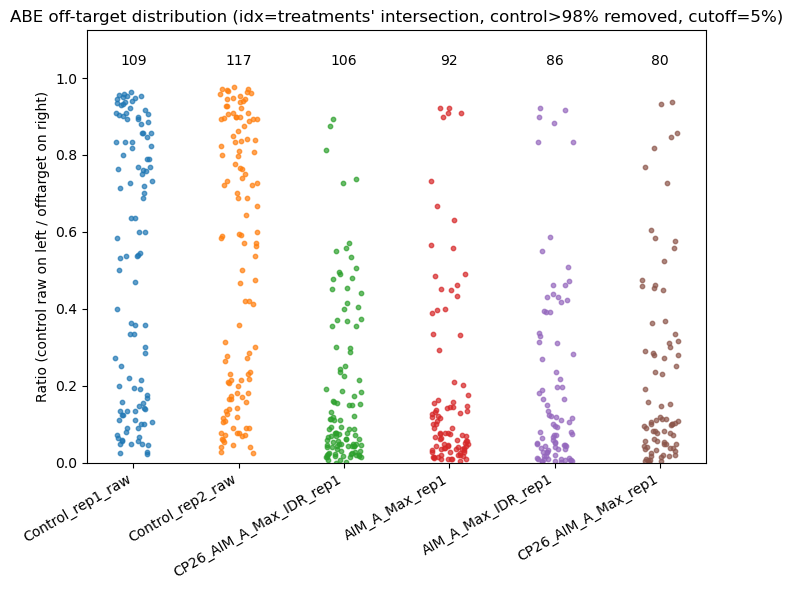

图已保存： offtarget_results/offtarget_jitterplot.png


In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
RNA ABE off-target 计算脚本（HG38，统一 cutoff=5% + 去掉 treatment 49–51%）
- Control: coverage≥10 后保留 5%–98%，并记录 >98% 位点集合（从所有 Treatment 直接剔除）
- Treatment: coverage≥10 且 mut_ratio≥5%，并额外剔除 [49%,51%] 的位点，再剔除 high98 集合
- idx: 所有 Treatment（经上述过滤后）的交集
- 背景扣除: offtarget = max(0, treat - bg_mean_on_idx)，Control 缺失当 0
- ABE 定向: ref=A 仅计 A->T；ref=G 仅计 G->C
- 去除 chrM/MT/Un/EBV；硬过滤 293T 背景（BED/VCF 合集）
- 左列绘 Control（在 idx 上的原始 mut_ratio），右列绘 Treatment offtarget；顶部标注数量；按 Treatment 脱靶点数降序
"""

import re
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =========================
# 参数区（只改这里）
# =========================
DATA_DIR = Path("../results_RNA-seq/mut_tables")

control_group = [
    "Control_rep1",
    "Control_rep2",
]

treatment_group = [
    "AIM_A_Max_IDR_rep1",
    "AIM_A_Max_rep1",
    "CP26_AIM_A_Max_IDR_rep1",
    "CP26_AIM_A_Max_rep1",
]

# 覆盖度阈值
COVERAGE_MIN = 10

# 比例阈值（本次统一为 2%）
CONTROL_LOWER = 0.02
CONTROL_UPPER = 0.98  # >98% 归入 high98 集合
TREAT_LOWER = 0.02
TREAT_UPPER = 0.99

# “准杂合/单倍型”疑似段（treatment 端直接剔除）
TREAT_HET_LOW, TREAT_HET_HIGH = 0.48, 0.52  # 含边界

# 背景（293T 固有变异/假阳性）文件目录
BG_DIR = Path(
    "~/1.database/db_genomes/cell_line_mutations/293T/293T_BE_INPUT_VCF"
).expanduser()
bg_files = [
    BG_DIR / "293T-EMX1-Mock-Input.site_index.rmdup.bed",
    BG_DIR / "293T_DddA11_FalsePositive_off-target-list.bed",
    BG_DIR
    / "293T-Mock-Input-covaris_bwa_hg38_sort_rmdup.recall.merge.Genotype.filter.rmdup_signal.vcf",
]

# 输出目录
OUT_DIR = Path("./offtarget_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"DATA_DIR        = {DATA_DIR.resolve()}")
print(f"BG_DIR          = {BG_DIR.resolve()}")
print(f"OUT_DIR         = {OUT_DIR.resolve()}")

print(f"control_group   = {control_group}")
print(f"treatment_group = {treatment_group}")
print(f"COVERAGE_MIN    = {COVERAGE_MIN}")
print(f"CONTROL range   = {CONTROL_LOWER}–{CONTROL_UPPER}")
print(f"TREAT range     = {TREAT_LOWER}–{TREAT_UPPER}")
print(f"TREAT del HET   = {TREAT_HET_LOW}-{TREAT_HET_HIGH}")


# =========================
# 基础工具函数
# =========================
def _read_filtered_table(path: Path) -> pd.DataFrame:
    """仅读 *.base_mut.filtered.tsv"""
    if not str(path).endswith(".base_mut.filtered.tsv"):
        raise ValueError(f"仅允许读取 *.base_mut.filtered.tsv，收到: {path}")
    df = pd.read_csv(path, sep="\t", dtype={"chr_name": str, "chr_index": int})
    need = [
        "chr_name",
        "chr_index",
        "ref_base",
        "A",
        "G",
        "C",
        "T",
        "del_count",
        "insert_count",
        "mut_num",
    ]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"{path} 缺少列: {miss}")
    return df[need]


def drop_non_nuclear(df: pd.DataFrame) -> pd.DataFrame:
    """移除 chrM/MT/Un/EBV 等非核染色体。"""
    df = df.copy()
    df["chr_name"] = df["chr_name"].astype(str)
    mask = ~df["chr_name"].str.match(r"^(chr)?(M|MT|Un|EBV)", flags=re.IGNORECASE)
    dropped = (~mask).sum()
    if dropped > 0:
        print(f"[非核染色体过滤] 移除 {dropped:,} 个位点 (chrM/Un等)")
    return df[mask]


def filter_for_ABE(df: pd.DataFrame) -> pd.DataFrame:
    """ABE 定向：ref=A 仅计 A->T；ref=G 仅计 G->C；重算 mut_num。"""
    df = df.copy()
    mask_A = df["ref_base"] == "A"
    df.loc[mask_A, ["A", "G", "C", "T"]] = df.loc[mask_A, ["A", "G", "C", "T"]].assign(
        A=0, G=0, C=0
    )
    df.loc[mask_A, "mut_num"] = df.loc[mask_A, "T"]
    mask_G = df["ref_base"] == "G"
    df.loc[mask_G, ["A", "G", "C", "T"]] = df.loc[mask_G, ["A", "G", "C", "T"]].assign(
        A=0, G=0, T=0
    )
    df.loc[mask_G, "mut_num"] = df.loc[mask_G, "C"]
    return df[df["ref_base"].isin(["A", "G"])]


def ensure_chr_pos(df: pd.DataFrame) -> pd.DataFrame:
    """补齐 chr/pos；chr 去掉前缀 'chr'。"""
    out = df.copy()
    if "chr" not in out.columns and "chr_name" in out.columns:
        out["chr"] = out["chr_name"].astype(str)
    if "pos" not in out.columns and "chr_index" in out.columns:
        out["pos"] = out["chr_index"].astype(int)
    out["chr"] = out["chr"].astype(str).str.replace(r"^chr", "", regex=True)
    return out


def filter_by_background(df: pd.DataFrame, bg_df: pd.DataFrame) -> pd.DataFrame:
    """硬过滤：去掉 (chr,pos) 在背景集内的位点。"""
    left = ensure_chr_pos(df)
    right = bg_df[["chr", "pos"]].drop_duplicates()
    merged = left.merge(right, how="left", on=["chr", "pos"], indicator=True)
    out = merged[merged["_merge"] == "left_only"].drop(columns="_merge")
    removed = len(left) - len(out)
    print(f"[背景过滤] 移除 {removed:,} 个位点；剩余 {len(out):,}。")
    return out


def compute_cov_ratio(df: pd.DataFrame) -> pd.DataFrame:
    """计算 coverage、mut_ratio；不做比例阈值过滤。"""
    out = ensure_chr_pos(df).copy()
    out["coverage"] = out[["A", "G", "C", "T", "del_count", "insert_count"]].sum(axis=1)
    out = out[out["coverage"] >= COVERAGE_MIN].copy()
    out = out[out["coverage"] > 0]
    out["mut_ratio"] = out["mut_num"] / out["coverage"]
    out = out[["chr", "pos", "coverage", "mut_ratio"]]
    out.index = pd.MultiIndex.from_frame(out[["chr", "pos"]])
    return out.sort_index()


def find_sample_file(prefix: str) -> Path:
    p = DATA_DIR / f"{prefix}.base_mut.filtered.tsv"
    if not p.exists():
        raise FileNotFoundError(f"未找到过滤文件：{p}")
    return p


def load_core(prefix: str) -> pd.DataFrame:
    """读取+去非核+ABE 定向+背景硬过滤+覆盖率筛选，返回带 MultiIndex 的 df。"""
    path = find_sample_file(prefix)
    df = _read_filtered_table(path)
    df = drop_non_nuclear(df)
    df = filter_for_ABE(df)
    df = filter_by_background(df, bg_all)
    df = compute_cov_ratio(df)
    return df


def save_with_chr_pos(df: pd.DataFrame, path: Path):
    """稳健导出：从 MultiIndex 拆出 (chr,pos) 两列到文件。"""
    out = df.copy()
    for c in ("chr", "pos"):
        if c in out.columns:
            out = out.drop(columns=[c])
    idx = out.index
    if isinstance(idx, pd.MultiIndex) and idx.nlevels >= 2:
        lv0 = pd.Series(idx.get_level_values(0).astype(str), index=idx)
        lv1 = pd.Series(idx.get_level_values(1).astype(str), index=idx)
        use0_as_pos = lv0.str.match(r"^\d+$").sum() >= lv1.str.match(r"^\d+$").sum()
        pos_raw = lv0 if use0_as_pos else lv1
        chr_raw = lv1 if use0_as_pos else lv0
        pos_num = pd.to_numeric(pos_raw, errors="coerce")
        mask = pos_num.notna()
        if (~mask).sum() > 0:
            print(f"[导出] 丢弃 {int((~mask).sum())} 行非数字坐标")
        out = out[mask]
        pos_num = pos_num[mask].astype(int)
        chr_clean = chr_raw[mask].str.replace(r"^chr", "", regex=True)
        out.insert(0, "chr", chr_clean.to_numpy())
        out.insert(1, "pos", pos_num.to_numpy())
        out.to_csv(path, sep="\t", index=False)
    else:
        out = out.reset_index(drop=False)
        cols = list(out.columns)
        if len(cols) >= 2:
            out = out.rename(columns={cols[0]: "chr", cols[1]: "pos"})
        out.to_csv(path, sep="\t", index=False)


# =========================
# 背景位点集合（BED/VCF 合集）
# =========================
bg_sites = []
for f in bg_files:
    if f.name.endswith(".bed"):
        bed = pd.read_csv(f, sep="\t", header=None, comment="#")
        if bed.shape[1] >= 3:
            bed.columns = ["chr", "start", "end"] + list(range(3, bed.shape[1]))
        else:
            continue
        bed["pos"] = bed["start"] + 1  # 0-based → 1-based
        bg_sites.append(bed[["chr", "pos"]])
    elif f.name.endswith(".vcf"):
        vcf = pd.read_csv(
            f, sep="\t", comment="#", usecols=[0, 1], names=["chr", "pos"], header=None
        )
        bg_sites.append(vcf[["chr", "pos"]])

if not bg_sites:
    raise RuntimeError("未读取到任何背景文件，请检查 bg_files")

bg_all = pd.concat(bg_sites, ignore_index=True).drop_duplicates()
bg_all["chr"] = bg_all["chr"].astype(str).str.replace(r"^chr", "", regex=True)
bg_all["pos"] = bg_all["pos"].astype(int)
print(f"背景位点总数: {len(bg_all):,}")

# =========================
# 读取 Control：拆分 filtered(5–98%) 与 high98(>98%)
# =========================
print("\n=== 载入 Control（5–98% 与 >98%） ===")
control_filtered = OrderedDict()  # 5–98%
control_high98 = OrderedDict()  # >98%

for s in control_group:
    core = load_core(s)
    cf = core[
        (core["mut_ratio"] >= CONTROL_LOWER) & (core["mut_ratio"] <= CONTROL_UPPER)
    ].copy()
    ch = core[(core["mut_ratio"] > CONTROL_UPPER)].copy()
    control_filtered[s] = cf
    control_high98[s] = ch
    print(f"{s}: filtered(5–98%)={len(cf):,} | high98(>98%)={len(ch):,}")

high98_union_idx = None
for s, df in control_high98.items():
    high98_union_idx = (
        df.index if high98_union_idx is None else high98_union_idx.union(df.index)
    )
n_high98 = 0 if high98_union_idx is None else len(high98_union_idx)
print(f"Control >98% 位点并集: {n_high98:,}")
if n_high98 > 0:
    tmp = pd.DataFrame(index=high98_union_idx).sort_index()
    save_with_chr_pos(tmp, OUT_DIR / "control_high98_sites.tsv")

# =========================
# 读取 Treatment：≥5%，剔除 [49%,51%]，再剔除 high98
# =========================
print("\n=== 载入 Treatment（≥5%，去49–51%，去 high98） ===")
treat_tables = OrderedDict()
for s in treatment_group:
    core = load_core(s)
    tf = core[core["mut_ratio"] >= TREAT_LOWER].copy()
    # 去掉 [49%, 51%] 准杂合段
    before = len(tf)
    tf = tf[
        ~((tf["mut_ratio"] >= TREAT_HET_LOW) & (tf["mut_ratio"] <= TREAT_HET_HIGH))
    ].copy()

    # 去掉极端值
    tf = tf[tf["mut_ratio"] <= TREAT_UPPER].copy()
    dropped_het = before - len(tf)
    # 再去 high98
    if n_high98 > 0:
        before2 = len(tf)
        tf = tf[~tf.index.isin(high98_union_idx)].copy()
        print(
            f"{s}: 去49–51% {dropped_het:,}；去 high98 {before2 - len(tf):,} / {before2:,}"
        )
    else:
        print(f"{s}: 去49–51% {dropped_het:,}")
    treat_tables[s] = tf
    print(f"{s}: 保留 {len(tf):,}")

# =========================
# idx = 所有 Treatment 的交集（以上过滤后）
# =========================
treatment_common_idx = None
for s, df in treat_tables.items():
    treatment_common_idx = (
        df.index
        if treatment_common_idx is None
        else treatment_common_idx.intersection(df.index)
    )
if treatment_common_idx is None or len(treatment_common_idx) == 0:
    raise RuntimeError("所有 treatment 之间没有共同位点（交集为空）。")
print(f"\nTreatment 共同位点（交集）数 = {len(treatment_common_idx):,}")

# =========================
# 背景均值（在 idx 上）；Control 缺失当 0
# =========================
bg_df = pd.DataFrame(index=treatment_common_idx)
for s, df in control_filtered.items():  # 用 5–98% 的 control
    series = df.reindex(treatment_common_idx)["mut_ratio"].fillna(0.0)
    bg_df[f"{s}_ratio"] = series.values
bg_df["bg_mean_ratio"] = bg_df[[c for c in bg_df.columns if c.endswith("_ratio")]].mean(
    axis=1
)
save_with_chr_pos(bg_df, OUT_DIR / "background_controls_on_idx.tsv")
print("背景表已保存：", OUT_DIR / "background_controls_on_idx.tsv")

# =========================
# 计算 offtarget = max(0, treat - bg_mean) 于 idx
# =========================
offtarget_tables = OrderedDict()
summary_rows = []
for s, tdf in treat_tables.items():
    t_use = tdf.reindex(treatment_common_idx)["mut_ratio"].fillna(0.0).values
    bg_mean = bg_df["bg_mean_ratio"].values
    offt = np.maximum(0.0, t_use - bg_mean)

    merged = pd.DataFrame(
        {"mut_ratio": t_use, "bg_mean_ratio": bg_mean, "offtarget_ratio": offt},
        index=treatment_common_idx,
    )
    out_path = OUT_DIR / f"{s}.offtarget.tsv"
    save_with_chr_pos(merged, out_path)
    offtarget_tables[s] = merged

    npos = int((offt > 0).sum())
    summary_rows.append(
        {
            "sample": s,
            "n_offtarget_sites": npos,
            "median_offtarget_ratio": (
                float(np.median(offt[offt > 0])) if npos > 0 else 0.0
            ),
            "mean_offtarget_ratio": float(np.mean(offt[offt > 0])) if npos > 0 else 0.0,
            "idx_sites": int(len(treatment_common_idx)),
        }
    )
    print(f"{s}: idx={len(treatment_common_idx)}，脱靶={npos}；结果 -> {out_path}")

summary_df = pd.DataFrame(summary_rows).sort_values(
    "n_offtarget_sites", ascending=False
)
summary_df.to_csv(OUT_DIR / "summary_offtarget_counts.tsv", sep="\t", index=False)
print("Summary 已保存：", OUT_DIR / "summary_offtarget_counts.tsv")
print(summary_df)

# =========================
# 左列：Control（5–98%）在 idx 上的原始分布；右列：Treatment offtarget
# =========================
for s, cdf in control_filtered.items():
    aligned = cdf.reindex(treatment_common_idx)["mut_ratio"].dropna()
    if len(aligned) == 0:
        continue
    offtarget_tables[f"{s}_raw"] = pd.DataFrame(
        {"offtarget_ratio": aligned.values}, index=aligned.index
    )

control_names_for_plot = [
    f"{s}_raw" for s in control_group if f"{s}_raw" in offtarget_tables
]
treat_order = summary_df["sample"].tolist()
samples_sorted = control_names_for_plot + treat_order

data = []
counts = []
for name in samples_sorted:
    df = offtarget_tables.get(name)
    if df is None:
        data.append(np.array([]))
        counts.append(0)
        continue
    if name.endswith("_raw"):
        arr = df["offtarget_ratio"].values  # 控制：原始 mut_ratio
    else:
        arr = df.loc[df["offtarget_ratio"] > 0, "offtarget_ratio"].values
    data.append(arr)
    counts.append(int((arr > 0).sum()))

x = np.arange(len(samples_sorted))
plt.figure(figsize=(max(6, len(samples_sorted) * 1.2), 6))

for i, arr in enumerate(data):
    if len(arr) == 0:
        continue
    jitter = (np.random.rand(len(arr)) - 0.5) * 0.35
    plt.scatter(np.full(len(arr), x[i]) + jitter, arr, s=10, alpha=0.7)

ymax = max([float(a.max()) for a in data if len(a) > 0], default=0.0)
for i, c in enumerate(counts):
    plt.text(
        x[i],
        ymax * 1.05 if ymax > 0 else 0.01,
        str(c),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xticks(x, samples_sorted, rotation=30, ha="right")
plt.ylabel("Ratio (control raw on left / offtarget on right)")
plt.title(
    "ABE off-target distribution (idx=treatments' intersection, control>98% removed, cutoff=5%)"
)
if ymax > 0:
    plt.ylim(0, ymax * 1.15)

fig_path = OUT_DIR / "offtarget_jitterplot.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=180)
plt.show()
print("图已保存：", fig_path)

DATA_DIR        = /lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2025_Others/GPZ_2025-10-26_RNA-seq/results_RNA-seq/mut_tables
BG_DIR          = /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/cell_line_mutations/293T/293T_BE_INPUT_VCF
OUT_DIR         = /lustre1/chengqiyi_pkuhpc/zhaohn/3.project/2025_Others/GPZ_2025-10-26_RNA-seq/snakepipes_RNA-seq/offtarget_results
control_group   = ['Control_rep1', 'Control_rep2']
treatment_group = ['AIM_A_Max_IDR_rep1', 'AIM_A_Max_rep1', 'CP26_AIM_A_Max_IDR_rep1', 'CP26_AIM_A_Max_rep1']
COVERAGE_MIN    = 20
CONTROL range   = 0.05–0.8
TREAT range     = 0.05–0.98
TREAT del HET   = 0.49-0.51
背景位点总数: 5,111,285

=== 载入 Control（2–98% 与 >98%） ===
[HET过滤-Control] Control_rep1: 剔除 185 个 HET 位点
Control_rep1: filtered(2–98%)=61,262 | high98(>98%)=741
[HET过滤-Control] Control_rep2: 剔除 289 个 HET 位点
Control_rep2: filtered(2–98%)=80,782 | high98(>98%)=935
Control >98% 位点并集: 1,040

=== 载入 Treatment（≥2%，去>99%，去 high98） ===
[HET过滤-Treat] AIM_A_Max_IDR_rep1: 剔除 406 

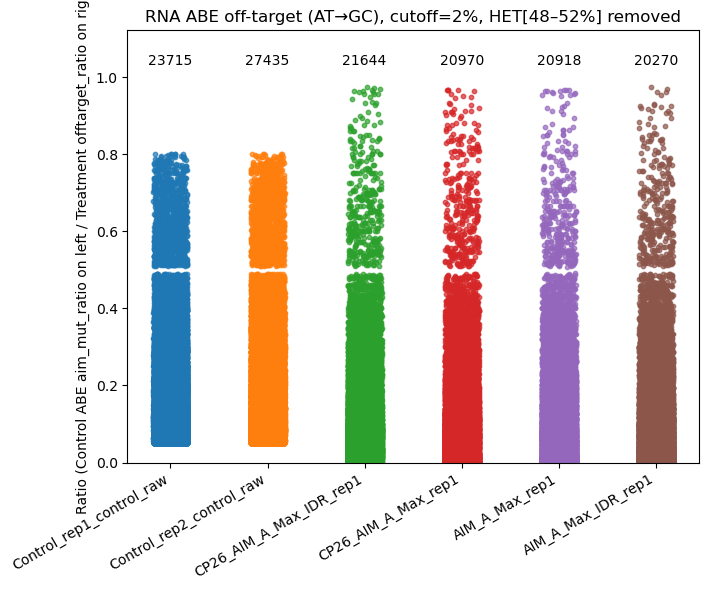

图已保存： offtarget_results/offtarget_jitterplot.png


In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
RNA ABE off-target 计算脚本（HG38，统一 cutoff=2% + 去掉 48–52% HET）

- ABE 目标：AT → GC
  * ref=A 时只看 A→G（即 G 列的计数）
  * ref=T 时只看 T→C（即 C 列的计数）
  用 aim_mut_count / aim_mut_ratio 表示 ABE 目标编辑比例，不再改动原始 mut_num。

- Control:
  1) coverage ≥ 10
  2) 计算 aim_mut_ratio（ABE 目标比例）
  3) 去掉 HET 区间 [48%,52%]
  4) 保留 2%–98% 作为 filtered，用于背景（bg_max）；>98% 收集成 high98 集合

- Treatment:
  1) coverage ≥ 10
  2) 计算 aim_mut_ratio（ABE 目标比例）
  3) 去掉 HET 区间 [48%,52%]
  4) 保留 aim_mut_ratio ≥ 2%
  5) 去掉 aim_mut_ratio > 99%
  6) 再从中去掉 Control high98 位点（并集）

- idx: 所有 Treatment（经上述过滤后）的交集

- 背景扣除:
  bg_max = 所有 control_filtered 在 idx 上的 aim_mut_ratio 的“逐位点最大值”（缺失当 0）
  offtarget = max(0, treat_aim_mut_ratio - bg_max)

- 背景硬过滤：提前剔除 293T 背景 BED/VCF 中的 (chr,pos) 位点
- 非核染色体过滤：剔除 chrM/MT/Un/EBV

- 图：
  左边：各 control 在 idx 上的原始 ABE 比例（aim_mut_ratio）
  右边：各 treatment 背景扣除后的 offtarget_ratio>0
"""

import re
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =========================
# 参数区
# =========================
DATA_DIR = Path("../results_RNA-seq/mut_tables")

control_group = [
    "Control_rep1",
    "Control_rep2",
]

treatment_group = [
    "AIM_A_Max_IDR_rep1",
    "AIM_A_Max_rep1",
    "CP26_AIM_A_Max_IDR_rep1",
    "CP26_AIM_A_Max_rep1",
]

# 覆盖度阈值
COVERAGE_MIN = 20

# 比例阈值（统一 2%）
CONTROL_LOWER = 0.05
CONTROL_UPPER = 0.8  # >98% 归入 high98 集合
TREAT_LOWER = 0.05
TREAT_UPPER = 0.98

# “准杂合/单倍型”疑似段（Control 和 Treatment 都剔除）
TREAT_HET_LOW, TREAT_HET_HIGH = 0.49, 0.51  # 含边界

# 背景（293T 固有变异/假阳性）文件目录
BG_DIR = Path(
    "~/1.database/db_genomes/cell_line_mutations/293T/293T_BE_INPUT_VCF"
).expanduser()
bg_files = [
    BG_DIR / "293T-EMX1-Mock-Input.site_index.rmdup.bed",
    BG_DIR / "293T_DddA11_FalsePositive_off-target-list.bed",
    BG_DIR
    / "293T-Mock-Input-covaris_bwa_hg38_sort_rmdup.recall.merge.Genotype.filter.rmdup_signal.vcf",
]

# 输出目录
OUT_DIR = Path("./offtarget_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"DATA_DIR        = {DATA_DIR.resolve()}")
print(f"BG_DIR          = {BG_DIR.resolve()}")
print(f"OUT_DIR         = {OUT_DIR.resolve()}")

print(f"control_group   = {control_group}")
print(f"treatment_group = {treatment_group}")
print(f"COVERAGE_MIN    = {COVERAGE_MIN}")
print(f"CONTROL range   = {CONTROL_LOWER}–{CONTROL_UPPER}")
print(f"TREAT range     = {TREAT_LOWER}–{TREAT_UPPER}")
print(f"TREAT del HET   = {TREAT_HET_LOW}-{TREAT_HET_HIGH}")

# =========================
# ABE 目标计数函数（Control / Treatment 共用）
# =========================
def abe_aim_count(r):
    """
    ABE 目标：AT → GC
    - ref=A: 看 G（A→G）
    - ref=T: 看 C（T→C）
    - ref=C/G: 非 ABE 目标，返回 0
    """
    if r["ref_base"] == "A":
        return r["G"]  # A→G
    elif r["ref_base"] == "T":
        return r["C"]  # T→C
    else:
        return 0       # 非 ABE 目标

# =========================
# 读取 293T 背景位点 (chr,pos)
# =========================
bg_dfs = []
for f in bg_files:
    if f.name.endswith(".bed"):
        # BED 文件是0-based, 且左闭右开[)，取 start + 1 即可
        # 假设 bed: chr start end ...
        bed = pd.read_csv(f, sep="\t", header=None, comment="#")
        if bed.shape[1] >= 3:
            bed.columns = ["chr", "start", "end"] + list(range(3, bed.shape[1]))
            bed["pos"] = bed["start"] + 1  # 0-based start → 1-based pos
            bg_dfs.append(bed[["chr", "pos"]])
    elif f.name.endswith(".vcf"):
        # VCF 文件是1-based, 且只标记一个单点
        # vcf: chr, pos, ...
        vcf = pd.read_csv(
            f,
            sep="\t",
            comment="#",
            header=None,
            usecols=[0, 1],
            names=["chr", "pos"],
        )
        bg_dfs.append(vcf[["chr", "pos"]])

if not bg_dfs:
    raise RuntimeError("未读取到任何背景文件，请检查 bg_files")

bg_all = pd.concat(bg_dfs, ignore_index=True).drop_duplicates()
# 去掉 chr 前缀保证和样本统一
bg_all["chr"] = bg_all["chr"].astype(str).str.replace(r"^chr", "", regex=True)
bg_all["pos"] = bg_all["pos"].astype(int)
print(f"背景位点总数: {len(bg_all):,}")

# =========================
# 处理 Control 样本
# =========================
print("\n=== 载入 Control（2–98% 与 >98%） ===")

control_filtered = OrderedDict()  # ABE aim_mut_ratio 在 2–98% 的位点
control_high98 = OrderedDict()    # ABE aim_mut_ratio > 98% 的位点

for sample in control_group:
    # 1) 读表
    path = DATA_DIR / f"{sample}.base_mut.filtered.tsv"
    df = pd.read_csv(path, sep="\t", dtype={"chr_name": str, "chr_index": int})

    # 只保留需要的列
    df = df[
        [
            "chr_name",
            "chr_index",
            "ref_base",
            "A",
            "G",
            "C",
            "T",
            "del_count",
            "insert_count",
            "mut_num",
        ]
    ]

    # 2) 去掉非核染色体 (chrM/MT/Un/EBV)
    mask_nuclear = (
        ~df["chr_name"]
        .astype(str)
        .str.match(r"^(chr)?(M|MT|Un|EBV)", flags=re.IGNORECASE)
    )
    df = df[mask_nuclear].copy()

    # 3) 统一坐标到 chr, pos（去掉 'chr' 前缀）
    df["chr"] = df["chr_name"].astype(str).str.replace(r"^chr", "", regex=True)
    df["pos"] = df["chr_index"].astype(int)

    # 4) 硬过滤 293T 背景位点：把 (chr,pos) 出现在 bg_all 里的都剔除
    df = df.merge(bg_all, on=["chr", "pos"], how="left", indicator=True)
    df = df[df["_merge"] == "left_only"].drop(columns=["_merge"])

    # 5) 计算 coverage
    df["coverage"] = df[["A", "G", "C", "T", "del_count", "insert_count"]].sum(axis=1)

    # 6) 只保留 coverage ≥ COVERAGE_MIN 的位点
    df = df[df["coverage"] >= COVERAGE_MIN].copy()

    # 7) 计算 ABE 目标计数 aim_mut_count（AT→GC）
    df["aim_mut_count"] = df.apply(abe_aim_count, axis=1)

    # 8) 计算 ABE 目标编辑比例 aim_mut_ratio
    df["aim_mut_ratio"] = df["aim_mut_count"] / df["coverage"]

    # 9) 统一在这里去掉 HET 区间 [48%,52%] 的位点（Control & Treatment 一致）
    het_mask = (df["aim_mut_ratio"] >= TREAT_HET_LOW) & (
        df["aim_mut_ratio"] <= TREAT_HET_HIGH
    )
    if het_mask.any():
        print(f"[HET过滤-Control] {sample}: 剔除 {het_mask.sum():,} 个 HET 位点")
    df = df[~het_mask].copy()

    # 10) 把 (chr,pos) 设为索引，方便之后做交集
    df = df.set_index(["chr", "pos"])

    # 11) 按 ABE 比例切分：
    #     - 2–98%: 用于背景 bg_max
    #     - >98%: 记录 high98 集合，后面在 Treatment 中剔除这些位点
    df_filtered = df[
        (df["aim_mut_ratio"] >= CONTROL_LOWER) & (df["aim_mut_ratio"] <= CONTROL_UPPER)
    ].copy()
    df_high98 = df[df["aim_mut_ratio"] > CONTROL_UPPER].copy()

    control_filtered[sample] = df_filtered
    control_high98[sample] = df_high98

    print(
        f"{sample}: filtered(2–98%)={len(df_filtered):,} | high98(>98%)={len(df_high98):,}"
    )

# 12) 把所有 Control 的 high98 位点合并成一个并集索引
high98_union_idx = None
for s, df in control_high98.items():
    if high98_union_idx is None:
        high98_union_idx = df.index
    else:
        high98_union_idx = high98_union_idx.union(df.index)

if high98_union_idx is None:
    n_high98 = 0
else:
    n_high98 = len(high98_union_idx)

print(f"Control >98% 位点并集: {n_high98:,}")

# 保存 high98 位点列表（坐标）
if n_high98 > 0:
    tmp = pd.DataFrame(index=high98_union_idx).sort_index().reset_index()
    tmp.to_csv(OUT_DIR / "control_high98_sites.tsv", sep="\t", index=False)

# =========================
# 处理 Treatment 样本
# =========================
print("\n=== 载入 Treatment（≥2%，去>99%，去 high98） ===")

treat_tables = OrderedDict()

for sample in treatment_group:
    # 和 Control 基本同样的预处理：读表、去非核、合并背景、计算 coverage 和 aim_mut_ratio、去 HET

    path = DATA_DIR / f"{sample}.base_mut.filtered.tsv"
    df = pd.read_csv(path, sep="\t", dtype={"chr_name": str, "chr_index": int})
    df = df[
        [
            "chr_name",
            "chr_index",
            "ref_base",
            "A",
            "G",
            "C",
            "T",
            "del_count",
            "insert_count",
            "mut_num",
        ]
    ]

    mask_nuclear = (
        ~df["chr_name"]
        .astype(str)
        .str.match(r"^(chr)?(M|MT|Un|EBV)", flags=re.IGNORECASE)
    )
    df = df[mask_nuclear].copy()

    df["chr"] = df["chr_name"].astype(str).str.replace(r"^chr", "", regex=True)
    df["pos"] = df["chr_index"].astype(int)

    df = df.merge(bg_all, on=["chr", "pos"], how="left", indicator=True)
    df = df[df["_merge"] == "left_only"].drop(columns=["_merge"])

    df["coverage"] = df[["A", "G", "C", "T", "del_count", "insert_count"]].sum(axis=1)
    df = df[df["coverage"] >= COVERAGE_MIN].copy()

    # 计算 ABE 目标计数与比例
    df["aim_mut_count"] = df.apply(abe_aim_count, axis=1)
    df["aim_mut_ratio"] = df["aim_mut_count"] / df["coverage"]

    het_mask = (df["aim_mut_ratio"] >= TREAT_HET_LOW) & (
        df["aim_mut_ratio"] <= TREAT_HET_HIGH
    )
    if het_mask.any():
        print(f"[HET过滤-Treat] {sample}: 剔除 {het_mask.sum():,} 个 HET 位点")
    df = df[~het_mask].copy()

    df = df.set_index(["chr", "pos"])

    # Treatment 专属过滤逻辑：
    # 1) aim_mut_ratio ≥ TREAT_LOWER (2%)
    # 2) aim_mut_ratio ≤ TREAT_UPPER (99%)
    df = df[df["aim_mut_ratio"] >= TREAT_LOWER].copy()
    before_upper = len(df)
    df = df[df["aim_mut_ratio"] <= TREAT_UPPER].copy()
    dropped_upper = before_upper - len(df)

    # 3) 去掉 Control high98 的位点（如果存在）
    if n_high98 > 0:
        before_high98 = len(df)
        df = df[~df.index.isin(high98_union_idx)].copy()
        dropped_high98 = before_high98 - len(df)
        print(
            f"{sample}: 去>99% {dropped_upper:,}；去 high98 {dropped_high98:,} / {before_high98:,}"
        )
    else:
        print(f"{sample}: 去>99% {dropped_upper:,}")

    treat_tables[sample] = df
    print(f"{sample}: 保留 {len(df):,}")

# =========================
# idx = 所有 Treatment 的交集（以上过滤后）
# =========================
treatment_common_idx = None
for s, df in treat_tables.items():
    if treatment_common_idx is None:
        treatment_common_idx = df.index
    else:
        treatment_common_idx = treatment_common_idx.intersection(df.index)

if treatment_common_idx is None or len(treatment_common_idx) == 0:
    raise RuntimeError("所有 treatment 之间没有共同位点（交集为空）。")

print(f"\nTreatment 共同位点（交集）数 = {len(treatment_common_idx):,}")

# =========================
# 背景（在 idx 上）；Control 缺失当 0，用 max 聚合
# =========================
bg_df = pd.DataFrame(index=treatment_common_idx)

# 从 control_filtered 里，把各样本在 idx 上的 aim_mut_ratio 填进来，缺失=0
for s, df in control_filtered.items():
    series = df.reindex(treatment_common_idx)["aim_mut_ratio"].fillna(0.0)
    bg_df[f"{s}_ratio"] = series.values

bg_cols = [c for c in bg_df.columns if c.endswith("_ratio")]

# 使用各 Control 样本的“最大值”作为背景 ABE 比例，避免低估 SNV
bg_df["bg_max_ratio"] = bg_df[bg_cols].max(axis=1)

bg_out = bg_df.reset_index()
bg_out.to_csv(OUT_DIR / "background_controls_on_idx.tsv", sep="\t", index=False)
print("背景表已保存：", OUT_DIR / "background_controls_on_idx.tsv")

# =========================
# 计算 offtarget = max(0, treat - bg_max) 于 idx
# =========================
offtarget_tables = OrderedDict()
summary_rows = []

for s, tdf in treat_tables.items():
    # 对齐到 idx
    treat_ratio = tdf.reindex(treatment_common_idx)["aim_mut_ratio"].fillna(0.0).values
    bg = bg_df["bg_max_ratio"].values

    # 脱靶比例：Treatment - 背景最大值，底噪以下视为 0
    offt = np.maximum(0.0, treat_ratio - bg)

    merged = pd.DataFrame(
        {
            "aim_mut_ratio": treat_ratio,
            "bg_max_ratio": bg,
            "offtarget_ratio": offt,
        },
        index=treatment_common_idx,
    )

    out_path = OUT_DIR / f"{s}.offtarget.tsv"
    merged.reset_index().to_csv(out_path, sep="\t", index=False)
    offtarget_tables[s] = merged

    npos = int((offt > 0).sum())
    summary_rows.append(
        {
            "sample": s,
            "n_offtarget_sites": npos,
            "median_offtarget_ratio": (
                float(np.median(offt[offt > 0])) if npos > 0 else 0.0
            ),
            "mean_offtarget_ratio": float(np.mean(offt[offt > 0])) if npos > 0 else 0.0,
            "idx_sites": int(len(treatment_common_idx)),
        }
    )
    print(f"{s}: idx={len(treatment_common_idx)}，脱靶={npos}；结果 -> {out_path}")

summary_df = pd.DataFrame(summary_rows).sort_values(
    "n_offtarget_sites", ascending=False
)
summary_df.to_csv(OUT_DIR / "summary_offtarget_counts.tsv", sep="\t", index=False)
print("Summary 已保存：", OUT_DIR / "summary_offtarget_counts.tsv")
print(summary_df)

# =========================
# 绘图：
# 左列：Control 在 idx 上的 ABE 原始比例（aim_mut_ratio）
# 右列：Treatment 的 offtarget_ratio>0
# =========================
control_names_for_plot = []
plot_data = []
plot_counts = []

# Control：直接用 aim_mut_ratio，在 idx 上对齐
for s, cdf in control_filtered.items():
    arr = cdf.reindex(treatment_common_idx)["aim_mut_ratio"].dropna().values
    name = f"{s}_control_raw"
    control_names_for_plot.append(name)
    plot_data.append(arr)
    plot_counts.append(int((arr > 0).sum()))

# Treatment：用 offtarget_ratio > 0
treat_order = summary_df["sample"].tolist()
for s in treat_order:
    df_off = offtarget_tables[s]
    arr = df_off["offtarget_ratio"].values
    arr = arr[arr > 0]  # 只看真正的脱靶
    plot_data.append(arr)
    plot_counts.append(int((arr > 0).sum()))

# X 轴名字：Control 在左，Treatment 在右
sample_names = control_names_for_plot + treat_order
x = np.arange(len(sample_names))

plt.figure(figsize=(max(6, len(sample_names) * 1.2), 6))

# 把每个样本的点画成 jitter 散点
for i, arr in enumerate(plot_data):
    if len(arr) == 0:
        continue
    jitter = (np.random.rand(len(arr)) - 0.5) * 0.35
    plt.scatter(np.full(len(arr), x[i]) + jitter, arr, s=10, alpha=0.7)

# 确定 Y 轴上限，并在顶部标注每个样本的位点数
ymax = max([float(a.max()) for a in plot_data if len(a) > 0], default=0.0)
for i, c in enumerate(plot_counts):
    plt.text(
        x[i],
        ymax * 1.05 if ymax > 0 else 0.01,
        str(c),
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xticks(x, sample_names, rotation=30, ha="right")
plt.ylabel(
    "Ratio (Control ABE aim_mut_ratio on left / Treatment offtarget_ratio on right)"
)
plt.title("RNA ABE off-target (AT→GC), cutoff=2%, HET[48–52%] removed")
if ymax > 0:
    plt.ylim(0, ymax * 1.15)

fig_path = OUT_DIR / "offtarget_jitterplot.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=180)
plt.show()
print("图已保存：", fig_path)

In [3]:
bg_all

,chr,pos
0,1,14654
1,1,14678
2,1,16299
3,1,17386
4,1,39225
...,...,...
5121945,M,15466
5121946,M,16192
5121947,M,16256
5121948,M,16270


In [5]:
df

chr_name  chr_index ref_base   A   G   C   T  del_count   
chr pos                                                                
1   14542        chr1      14542        A  27   5   0   0          0  \
    14574        chr1      14574        A  35   7   0   0          0   
    14604        chr1      14604        A  41   8   0   0          0   
    14610        chr1      14610        T   0   0  15  45          0   
    16996        chr1      16996        T   0   0  30  43          0   
...               ...        ...      ...  ..  ..  ..  ..        ...   
Y   11162733     chrY   11162733        A  42  20   0   0          0   
    11162925     chrY   11162925        A  26   2   0   0          0   
    11167396     chrY   11167396        T   0   0   2  27          0   
    11176115     chrY   11176115        T   0   0   2  32          0   
    11202807     chrY   11202807        T   0   0  14   9          0   

              insert_count  mut_num  coverage  aim_mut_count  aim_mut_ratio  
chr pos                                                                      
1   14542                0        5        32              5       0.156250  
    14574                0        7        42              7       0.166667  
    14604                0        8        49              8       0.163265  
    14610                0       15        60             15       0.250000  
    16996                0       30        73             30       0.410959  
...                    ...      ...       ...            ...            ...  
Y   11162733             0       20        62             20       0.322581  
    11162925             0        2        28              2       0.071429  
    11167396             0        2        29              2       0.068966  
    11176115             0        2        34              2       0.058824  
    11202807             0       14        23             14       0.608696  

[80782 rows x 13 columns]